In [181]:
import sys
import os
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
import keras

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.split_utils import min_rating_filter_pandas
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

from recommenders.datasets.sparse import AffinityMatrix
from recommenders.utils.python_utils import binarize
from recommenders.models.vae.multinomial_vae import Mult_VAE

from tempfile import TemporaryDirectory

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

System version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Pandas version: 1.4.2
Tensorflow version: 2.9.1
Keras version: 2.9.0


In [182]:
import time
import datetime
from datetime import datetime
from tqdm import tqdm

# 하이퍼 파라미터 설정

In [183]:
# top k items to recommend
TOP_K = 100

# Model parameters
HELDOUT_USERS = 600 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 30
BATCH_SIZE = 100

# temporary Path to save the optimal model's weights
root_dir = '/opt/ml/amazon/model/'
WEIGHTS_PATH = os.path.join(root_dir, "mvae_weights.hdf5")

SEED = 98765

# 데이터 불러오기

In [184]:
df = pd.read_parquet('merge_book_sentiment_2015_30_5.parquet', engine='pyarrow')

In [185]:
df = df[['reviewerID', 'asin', 'overall', 'unixReviewTime','review_sentiment_score']]
df.columns=['userID', 'itemID', 'rating', 'timestamp','sentiment_rating']

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823358 entries, 0 to 823357
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userID            823358 non-null  object 
 1   itemID            823358 non-null  object 
 2   rating            823358 non-null  int16  
 3   timestamp         823358 non-null  float64
 4   sentiment_rating  823236 non-null  float64
dtypes: float64(2), int16(1), object(2)
memory usage: 26.7+ MB


In [187]:
df.rating.value_counts()

5    543774
4    205231
3     52868
2     13756
1      7729
Name: rating, dtype: int64

In [193]:
df['rating'] = df.apply(lambda x : 2 if x.sentiment_rating<0.5 and x.rating>2 else x['rating'],axis=1)

In [194]:
df.rating.value_counts()

5    536381
4    191564
2     58386
3     29298
1      7729
Name: rating, dtype: int64

### Label encoding
- userID, itemID를 원본인 object로 하면 train할 때 문제생김
- Scikit-learn의 LabelEncoder로 인코딩 후 학습

In [195]:
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(df['userID'])
df['le_userID'] = le_user.transform(df['userID'])
le_item = preprocessing.LabelEncoder()
le_item.fit(df['itemID'])
df['le_itemID'] = le_item.transform(df['itemID'])

In [196]:
# class 확인 method
le_user.classes_

# 원본으로 변환할 때 method
le_user.inverse_transform([0, 0, 1, 2])

array(['A0020356UF96ZV361ST', 'A0020356UF96ZV361ST',
       'A0061296P44YI9YQBDHH', 'A0119044X1GAIYGKN8J1'], dtype=object)

In [197]:
df

,userID,itemID,rating,timestamp,sentiment_rating,le_userID,le_itemID
0,ALUGXJE8QRTT8,0001384198,2,1.467158e+09,0.408181,10202,6
1,AJ133AQBUHY7B,0001384198,4,1.460678e+09,0.619280,9957,6
2,ATO9XRWKWG13I,0001384198,5,1.425600e+09,0.989993,10890,6
3,A32TLMERXASISG,0001716069,5,1.441152e+09,0.922831,6245,10
4,A1N3Q5GDH2VG23,0001720392,5,1.513901e+09,0.970058,1940,12
...,...,...,...,...,...,...,...
823353,A3OMONOB2FE5JB,B01HHZ9AOM,2,1.519344e+09,0.021042,8062,69892
823354,A2UGP5O2SIAKPD,B01HHZ9AOM,4,1.467590e+09,0.996520,5517,69892
823355,A1FMG24RFTCLT,B01HI9W5HQ,3,1.529194e+09,0.990771,1319,69893
823356,A6ZT9EZ49JTEL,B01HJ56VC4,3,1.499213e+09,0.979841,8969,69894


In [198]:
# from sklearn.preprocessing import MinMaxScaler

# # Standardization 평균 0 / 분산 1
# a = df[df.le_userID==31931]
# scaler = MinMaxScaler()   
# scaler = scaler.fit_transform(a[['rating']])

# # # 교차검증시
# # scaler.fit(X_train)
# # X_train = scaler.transform(X_train)

In [199]:
# Binarize the data (only keep ratings >= 4)
df_preferred = df[df['rating'] >= 3]
print (df_preferred.shape)
df_low_rating = df[df['rating'] < 3]


# df.head()
df_preferred.head(10)

(757243, 7)


,userID,itemID,rating,timestamp,sentiment_rating,le_userID,le_itemID
1,AJ133AQBUHY7B,0001384198,4,1.460678e+09,0.619280,9957,6
2,ATO9XRWKWG13I,0001384198,5,1.425600e+09,0.989993,10890,6
3,A32TLMERXASISG,0001716069,5,1.441152e+09,0.922831,6245,10
4,A1N3Q5GDH2VG23,0001720392,5,1.513901e+09,0.970058,1940,12
5,A3L4TODGKQWRA1,0001720392,3,1.508544e+09,0.527478,7794,12
6,A3D9RPBNOYKNHR,0001046519,5,1.517875e+09,0.908524,7120,2
7,A25VZ9FHZNAKKI,0001046519,5,1.516147e+09,0.998860,3543,2
8,A1ZUPWA08D11Z6,0001720392,5,1.496534e+09,0.987640,3010,12
9,A2G2QYF9JBLV9T,0001720392,5,1.480550e+09,0.999242,4375,12
10,A17FBSRID0HBWE,0001720392,5,1.478563e+09,0.980836,634,12


In [200]:
len(df_low_rating)

66115

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823358 entries, 0 to 823357
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userID            823358 non-null  object 
 1   itemID            823358 non-null  object 
 2   rating            823358 non-null  int64  
 3   timestamp         823358 non-null  float64
 4   sentiment_rating  823236 non-null  float64
 5   le_userID         823358 non-null  int64  
 6   le_itemID         823358 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 44.0+ MB


### 횟수로 필터링
- 평가된 횟수로 영화 필터링
- 유저가 평가한 횟수로 영화 필터링

In [202]:
# # # Keep users who clicked on at least 5 movies
# df = min_rating_filter_pandas(df_preferred, min_rating=20, filter_by="user")

In [203]:
# # Keep movies that were clicked on by at least on 1 user
# df = min_rating_filter_pandas(df, min_rating=5, filter_by="item")

In [204]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 823358 watching events from 11380 users and 69895 movies (sparsity: 0.104%)


In [205]:
unique_users = sorted(df.userID.unique())
np.random.seed(SEED)
unique_users = np.random.permutation(unique_users)

In [206]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - HELDOUT_USERS * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - HELDOUT_USERS * 2) : (n_users - HELDOUT_USERS)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - HELDOUT_USERS):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 11380

Number of training users: 10180

Number of validation users: 600

Number of test users: 600


In [207]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

# train_set/val_set/test_set contain user - movie interactions with rating 4 or 5

Number of training observations:  739570

Number of validation observations:  41670

Number of test observations:  42118


In [208]:
# Obtain list of unique movies used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique movies that rated in training set", unique_train_items.size)

Number of unique movies that rated in training set 69241


In [209]:
# For validation set keep only movies that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  41234

Number of test observations after filtering:  41795


### Matrix 생성

In [210]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [211]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(10180, 69241)
(600, 69241)
(600, 69241)


### 데이터 split
- train, test 비율 설정 가능

In [212]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [213]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=3)
val_data = binarize(a=val_data, threshold=3)
test_data = binarize(a=test_data, threshold=3)

In [214]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=3)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=3)

In [215]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=3)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=3)

In [216]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
    user_old= i['userID'] # old value 
    item_old=i['itemID'] # old value 

    if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
        user_new=test_map_users.get(user_old) # new value 
        item_new=test_map_items.get(item_old) # new value 
        rating=i['rating'] 
        test_data_te_ratings.at[user_new,item_new]= rating
        
    if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
        user_new=val_map_users.get(user_old) # new value 
        item_new=val_map_items.get(item_old) # new value 
        rating=i['rating'] 
        val_data_te_ratings.at[user_new,item_new]= rating   


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    
# test_data_te_ratings 

# Multi-VAE

In [217]:
model_without_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS,
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
#                                 verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=False,
                                beta=1.0
                                )

In [218]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                             x_valid=val_data, 
                             x_val_tr=val_data_tr, 
                             x_val_te=val_data_te_ratings, 
                             mapper=am_val
                             )
print("Took {} seconds for training.".format(t))

Epoch 1/30


/opt/conda/lib/python3.8/site-packages/recommenders/models/vae/multinomial_vae.py:458: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


101/101 [==============================] - ETA: 0s - batch: 50.0000 - size: 100.0000 - loss: 686.9733

/opt/conda/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/opt/conda/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


101/101 [==============================] - 41s 334ms/step - batch: 50.0000 - size: 100.0000 - loss: 686.9733 - val_loss: 631.2164 - lr: 0.0010
Epoch 2/30
101/101 [==============================] - 33s 332ms/step - batch: 50.0000 - size: 100.0000 - loss: 666.4340 - val_loss: 624.8865 - lr: 0.0010
Epoch 3/30
101/101 [==============================] - 34s 334ms/step - batch: 50.0000 - size: 100.0000 - loss: 654.2062 - val_loss: 609.7299 - lr: 0.0010
Epoch 4/30
101/101 [==============================] - 33s 329ms/step - batch: 50.0000 - size: 100.0000 - loss: 637.2879 - val_loss: 596.4702 - lr: 0.0010
Epoch 5/30
101/101 [==============================] - 33s 329ms/step - batch: 50.0000 - size: 100.0000 - loss: 625.6061 - val_loss: 587.9620 - lr: 0.0010
Epoch 6/30
101/101 [==============================] - 34s 334ms/step - batch: 50.0000 - size: 100.0000 - loss: 614.8697 - val_loss: 578.6779 - lr: 0.0010
Epoch 7/30
101/101 [==============================] - 34s 336ms/step - batch: 50.0000 -

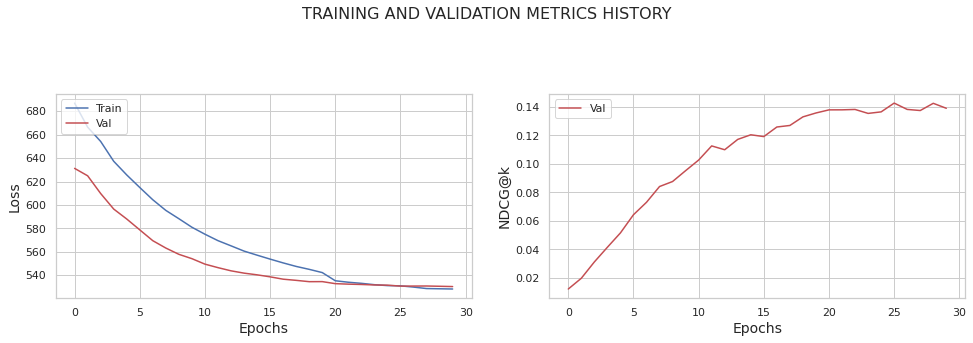

In [219]:
model_without_anneal.display_metrics()

# Test

### 3~5 threshold 3, 감성점수 0.5 미만인것들은 다 2점으로

In [220]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 2.4515 seconds for prediction.
MAP@10:		0.029575
NDCG@10:	0.100962
Precision@10:	0.092667
Recall@10: 	0.052090


### 3~5 threshold 3.5

In [180]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 2.4667 seconds for prediction.
MAP@10:		0.032117
NDCG@10:	0.103023
Precision@10:	0.093667
Recall@10: 	0.057591


### 3~5 threshold 3

In [145]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 2.4563 seconds for prediction.
MAP@10:		0.035307
NDCG@10:	0.109805
Precision@10:	0.096500
Recall@10: 	0.059341


### sentiment 긍정 +1, 부정 -1 , 기준 rating 3

In [110]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 2.4128 seconds for prediction.
MAP@10:		0.034661
NDCG@10:	0.112285
Precision@10:	0.103000
Recall@10: 	0.060456


### sentiment 긍정 +0.5, 부정 -0.5 , 기준 rating 3.5

In [40]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 2.3941 seconds for prediction.
MAP@10:		0.033190
NDCG@10:	0.108909
Precision@10:	0.098500
Recall@10: 	0.058950


### sentiment 0.5

In [68]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 2.6226 seconds for prediction.
MAP@10:		0.029043
NDCG@10:	0.099178
Precision@10:	0.090833
Recall@10: 	0.051179


# Inference